<a href="https://colab.research.google.com/github/eliza-wollinger/battery-degradation/blob/main/battery_degradation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "bertnardomariouskono/electric-vehicle-ev-battery-degradation-and-charge",
    path="ev_battery_degradation_v1.csv"
)

print(df.head())

100%|██████████| 849k/849k [00:00<00:00, 2.97MB/s]

  Vehicle_ID            Car_Model Battery_Type  Battery_Capacity_kWh  \
0   1fb46ae8        Tesla Model 3          NMC                  75.0   
1   b7ef35aa        Tesla Model 3          NMC                  75.0   
2   76cb49e0  Ford Mustang Mach-E          NMC                  88.0   
3   456a7aef  Ford Mustang Mach-E          NMC                  88.0   
4   bd758049        Tesla Model 3          NMC                  75.0   

   Vehicle_Age_Months  Total_Charging_Cycles  Avg_Temperature_C  \
0                  41                    390               21.5   
1                  29                    401               18.0   
2                  71                    941               18.4   
3                  57                    378               10.8   
4                  58                    239               30.3   

   Fast_Charge_Ratio  Avg_Discharge_Rate_C Driving_Style  \
0               0.51                  2.22    Aggressive   
1               0.62                  1.34  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
import os
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
le_car = LabelEncoder()
le_battery = LabelEncoder()
le_driving = LabelEncoder()

df['Car_Model_Encoded'] = le_car.fit_transform(df['Car_Model'])
df['Battery_Type_Encoded'] = le_battery.fit_transform(df['Battery_Type'])
df['Driving_Style_Encoded'] = le_driving.fit_transform(df['Driving_Style'])

print(f"Car models: {', '.join(le_car.classes_)}")
print(f"Battery type: {', '.join(le_battery.classes_)}")
print(f"Direction style: {', '.join(le_driving.classes_)}")

feature_cols = [
    'Battery_Capacity_kWh', 'Vehicle_Age_Months', 'Total_Charging_Cycles',
    'Avg_Temperature_C', 'Fast_Charge_Ratio', 'Avg_Discharge_Rate_C',
    'Driving_Style_Encoded', 'Internal_Resistance_Ohm'
]

X = df[feature_cols]
y = df['SoH_Percent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nSepareted data: {X_train.shape[0]} train, {X_test.shape[0]} test")


Car models: BYD Atto 3, Ford Mustang Mach-E, Hyundai Ioniq 5, Tesla Model 3, Wuling Air EV
Battery type: LFP, NMC
Direction style: Aggressive, Conservative, Moderate

Separeted data: 8000 train, 2000 test


In [ ]:
# Random Forest
print("Random Forest")
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print(f"   R² Score: {rf_r2:.4f}")
print(f"   MAE: {rf_mae:.4f}%")
print(f"   RMSE: {rf_rmse:.4f}%")

Random Forest
   R² Score: 0.9866
   MAE: 0.2894%
   RMSE: 0.3771%


In [ ]:
# Gradient Boosting
print("Gradient Boosting:")
gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_r2 = r2_score(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))

print(f"   R² Score: {gb_r2:.4f}")
print(f"   MAE: {gb_mae:.4f}%")
print(f"   RMSE: {gb_rmse:.4f}%")

Gradient Boosting:
   R² Score: 0.9879
   MAE: 0.2763%
   RMSE: 0.3583%


In [ ]:
best_model = rf_model if rf_r2 > gb_r2 else gb_model
best_model_name = "Random Forest" if rf_r2 > gb_r2 else "Gradient Boosting"
best_r2 = max(rf_r2, gb_r2)
best_mae = min(rf_mae, gb_mae)
best_rmse = min(rf_rmse, gb_rmse)

print(f"Best model: {best_model_name}")
print(f"   R²: {best_r2:.4f} | MAE: {best_mae:.4f}% | RMSE: {best_rmse:.4f}%")

Best model: Gradient Boosting
   R²: 0.9879 | MAE: 0.2763% | RMSE: 0.3583%


In [ ]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"TOP 5 Features Mais Importantes:")
for idx, row in feature_importance.head(5).iterrows():
    bar = '█' * int(row['Importance'] * 50)
    print(f"   {row['Feature']:30s} {bar} {row['Importance']:.3f}")

TOP 5 Features Mais Importantes:
   Internal_Resistance_Ohm        ███████████████████████████████████████████████ 0.950
   Total_Charging_Cycles          █ 0.031
   Battery_Capacity_kWh            0.013
   Fast_Charge_Ratio               0.002
   Avg_Temperature_C               0.002


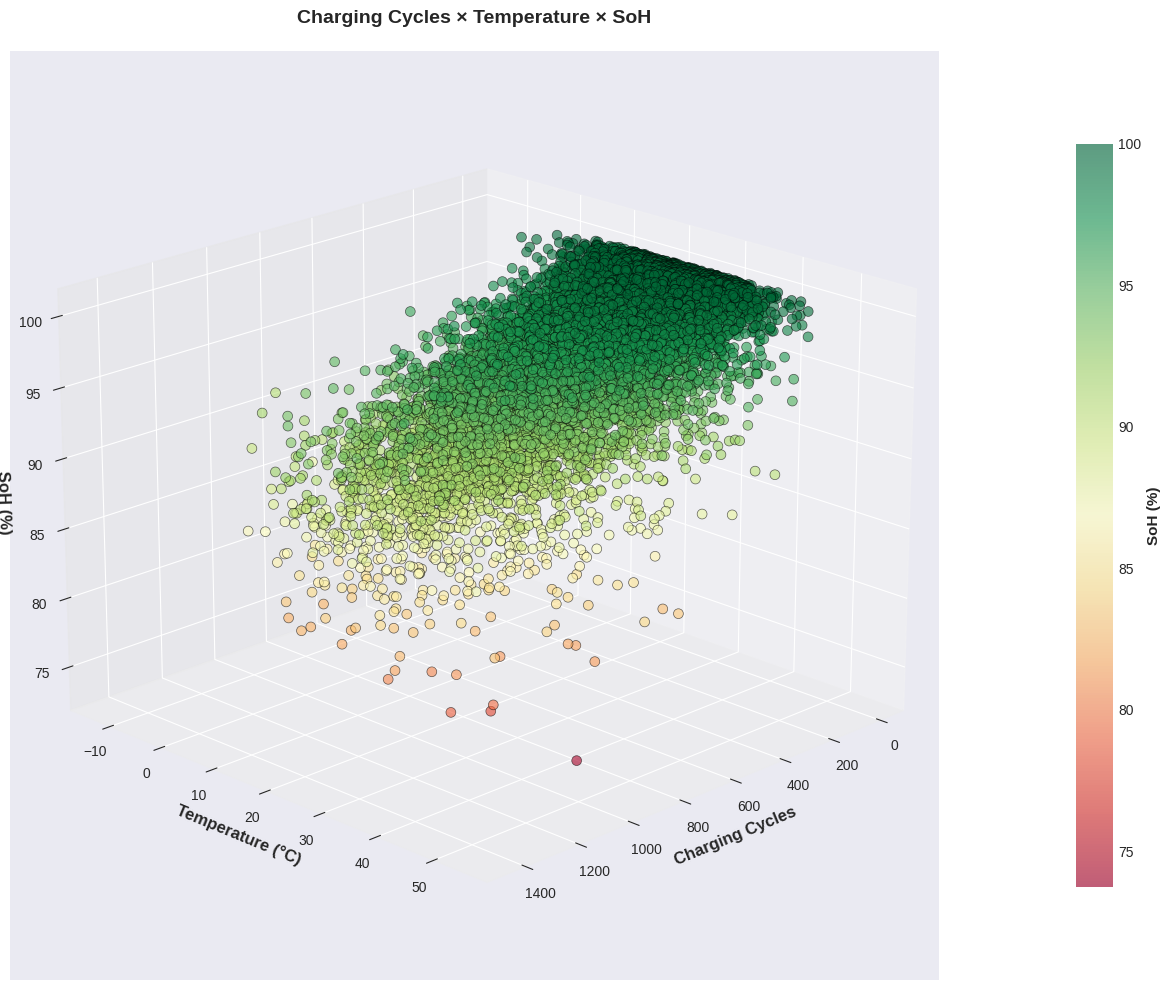

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Total_Charging_Cycles'],
    df['Avg_Temperature_C'],
    df['SoH_Percent'],
    c=df['SoH_Percent'],
    cmap='RdYlGn',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('Charging Cycles', fontsize=12, fontweight='bold')
ax.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_zlabel('SoH (%)', fontsize=12, fontweight='bold')
ax.set_title('Charging Cycles × Temperature × SoH', fontsize=14, fontweight='bold', pad=20)
cbar = fig.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('SoH (%)', fontsize=11, fontweight='bold')
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

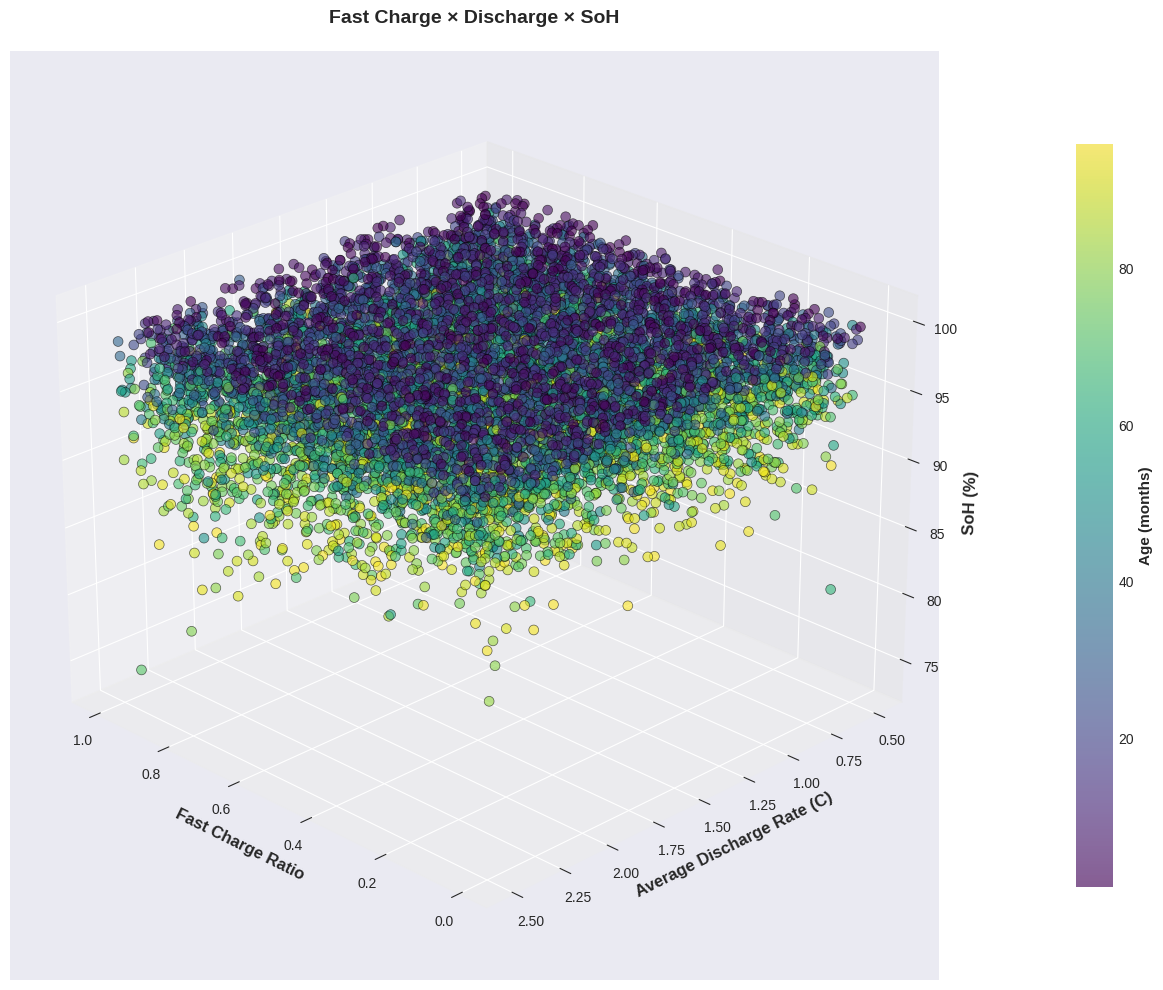

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Fast_Charge_Ratio'],
    df['Avg_Discharge_Rate_C'],
    df['SoH_Percent'],
    c=df['Vehicle_Age_Months'],
    cmap='viridis',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('Fast Charge Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Discharge Rate (C)', fontsize=12, fontweight='bold')
ax.set_zlabel('SoH (%)', fontsize=12, fontweight='bold')
ax.set_title('Fast Charge × Discharge × SoH', fontsize=14, fontweight='bold', pad=20)
cbar = fig.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Age (months)', fontsize=11, fontweight='bold')
ax.view_init(elev=25, azim=135)
plt.tight_layout()
plt.show()

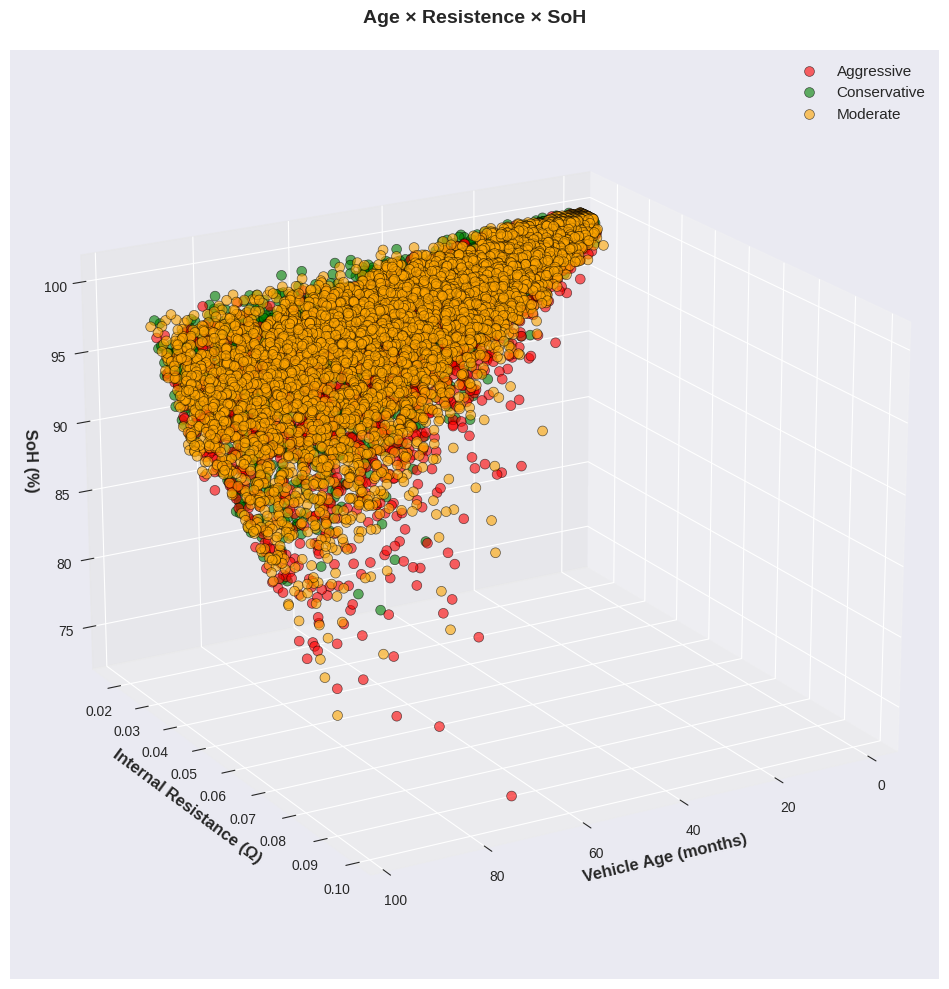

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

colors = {'Aggressive': 'red', 'Moderate': 'orange', 'Conservative': 'green'}
for style in df['Driving_Style'].unique():
    df_style = df[df['Driving_Style'] == style]
    ax.scatter(
        df_style['Vehicle_Age_Months'],
        df_style['Internal_Resistance_Ohm'],
        df_style['SoH_Percent'],
        c=colors[style],
        label=style,
        s=50,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('Vehicle Age (months)', fontsize=12, fontweight='bold')
ax.set_ylabel('Internal Resistance (Ω)', fontsize=12, fontweight='bold')
ax.set_zlabel('SoH (%)', fontsize=12, fontweight='bold')
ax.set_title('Age × Resistence × SoH', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=11)
ax.view_init(elev=20, azim=60)
plt.tight_layout()
plt.show()

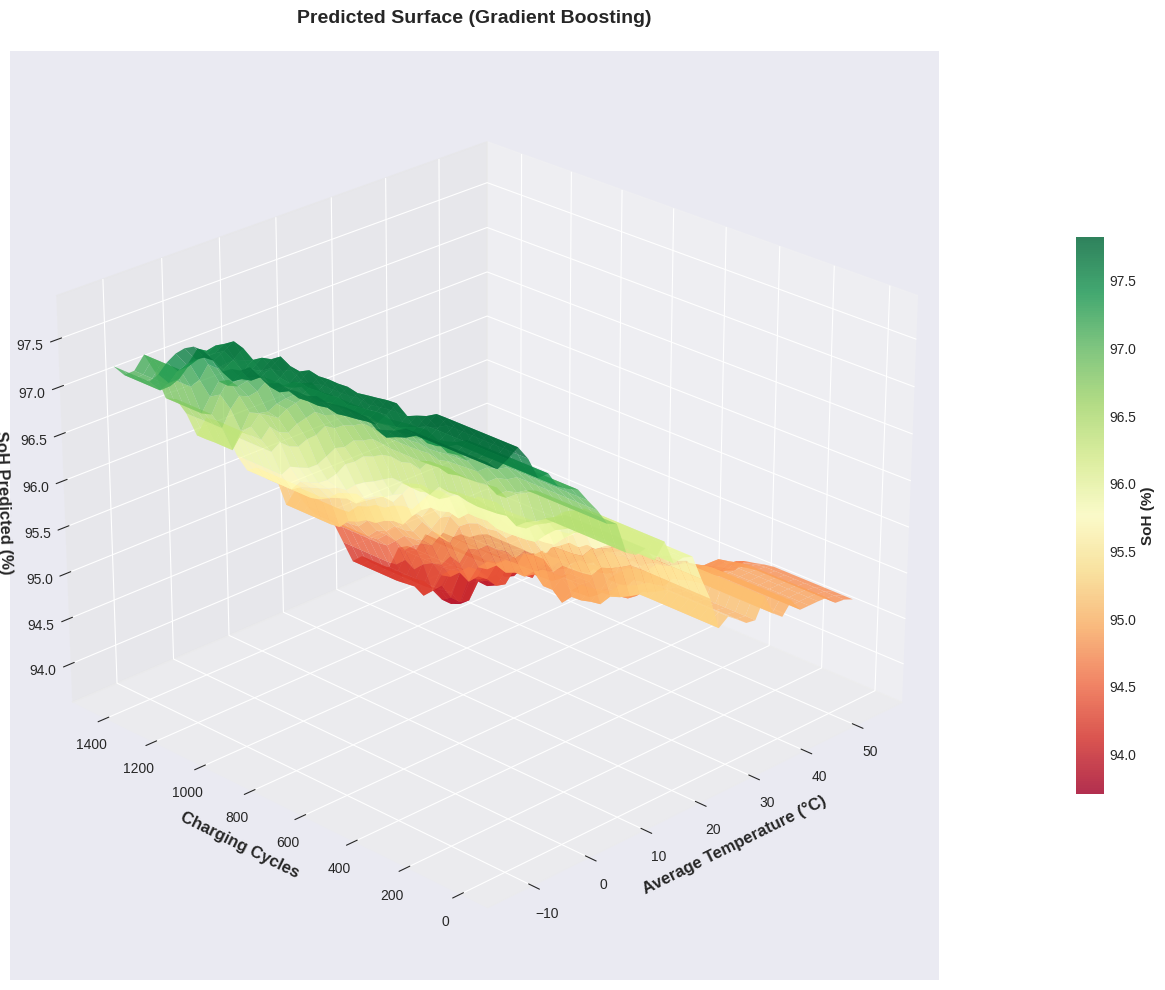

In [ ]:
temp_range = np.linspace(df['Avg_Temperature_C'].min(), df['Avg_Temperature_C'].max(), 40)
cycles_range = np.linspace(df['Total_Charging_Cycles'].min(), df['Total_Charging_Cycles'].max(), 40)
temp_grid, cycles_grid = np.meshgrid(temp_range, cycles_range)

median_values = X.median()
pred_data = []
for i in range(len(temp_range)):
    for j in range(len(cycles_range)):
        row = median_values.copy()
        row['Avg_Temperature_C'] = temp_grid[j, i]
        row['Total_Charging_Cycles'] = cycles_grid[j, i]
        pred_data.append(row)

pred_df = pd.DataFrame(pred_data)
soh_predictions = best_model.predict(pred_df)
soh_grid = soh_predictions.reshape(temp_grid.shape)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(temp_grid, cycles_grid, soh_grid, cmap='RdYlGn', alpha=0.8, edgecolor='none')
ax.set_xlabel('Average Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Charging Cycles', fontsize=12, fontweight='bold')
ax.set_zlabel('SoH Predicted (%)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicted Surface ({best_model_name})', fontsize=14, fontweight='bold', pad=20)
cbar = fig.colorbar(surf, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label('SoH (%)', fontsize=11, fontweight='bold')
ax.view_init(elev=25, azim=225)
plt.tight_layout()
plt.show()

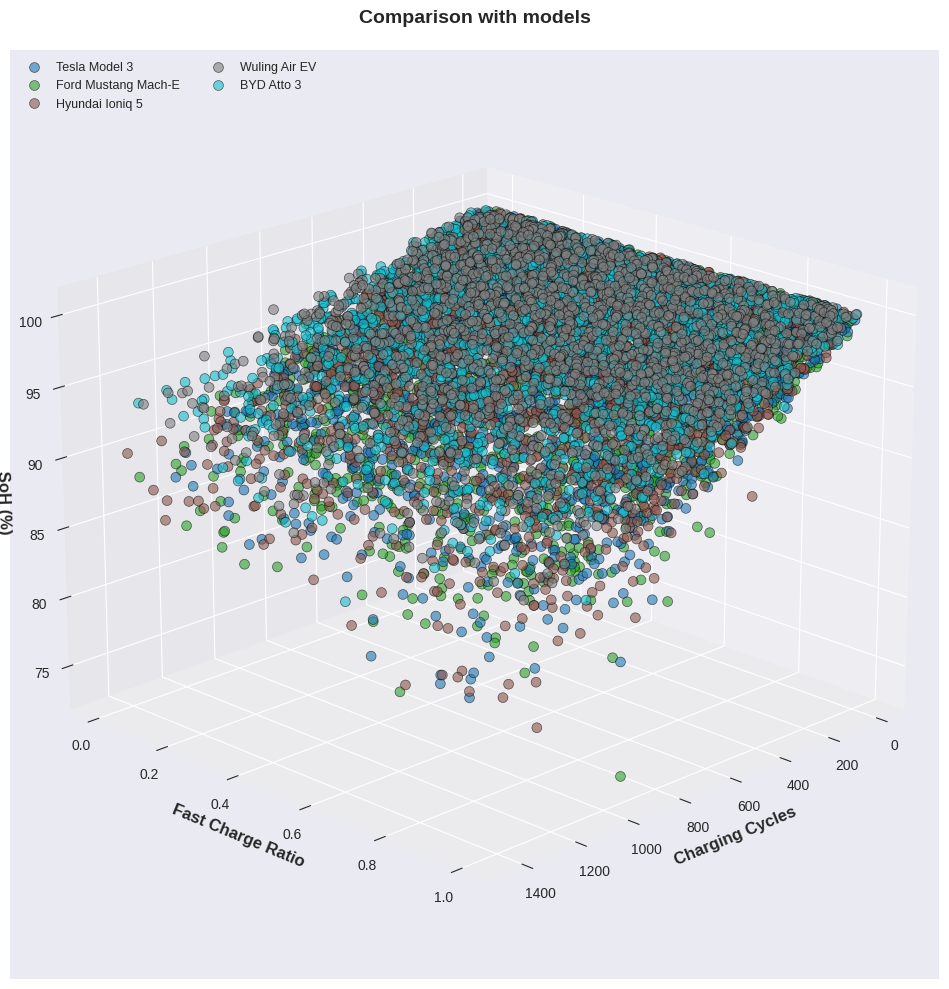

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

car_colors = plt.cm.tab10(np.linspace(0, 1, len(df['Car_Model'].unique())))
for idx, model in enumerate(df['Car_Model'].unique()):
    df_model = df[df['Car_Model'] == model]
    ax.scatter(
        df_model['Total_Charging_Cycles'],
        df_model['Fast_Charge_Ratio'],
        df_model['SoH_Percent'],
        c=[car_colors[idx]],
        label=model,
        s=50,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('Charging Cycles', fontsize=12, fontweight='bold')
ax.set_ylabel('Fast Charge Ratio', fontsize=12, fontweight='bold')
ax.set_zlabel('SoH (%)', fontsize=12, fontweight='bold')
ax.set_title('Comparison with models', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

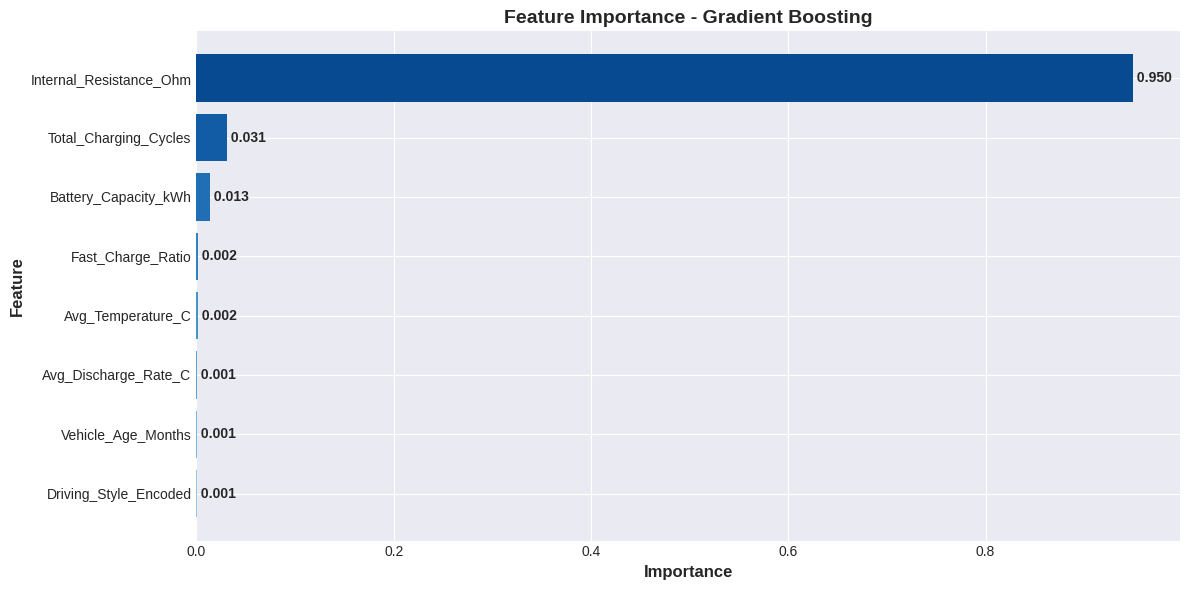

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
feature_importance_sorted = feature_importance.sort_values('Importance')
colors_bar = plt.cm.Blues(np.linspace(0.4, 0.9, len(feature_importance_sorted)))
bars = ax.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Importance'], color=colors_bar)
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f' {width:.3f}',
            ha='left', va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

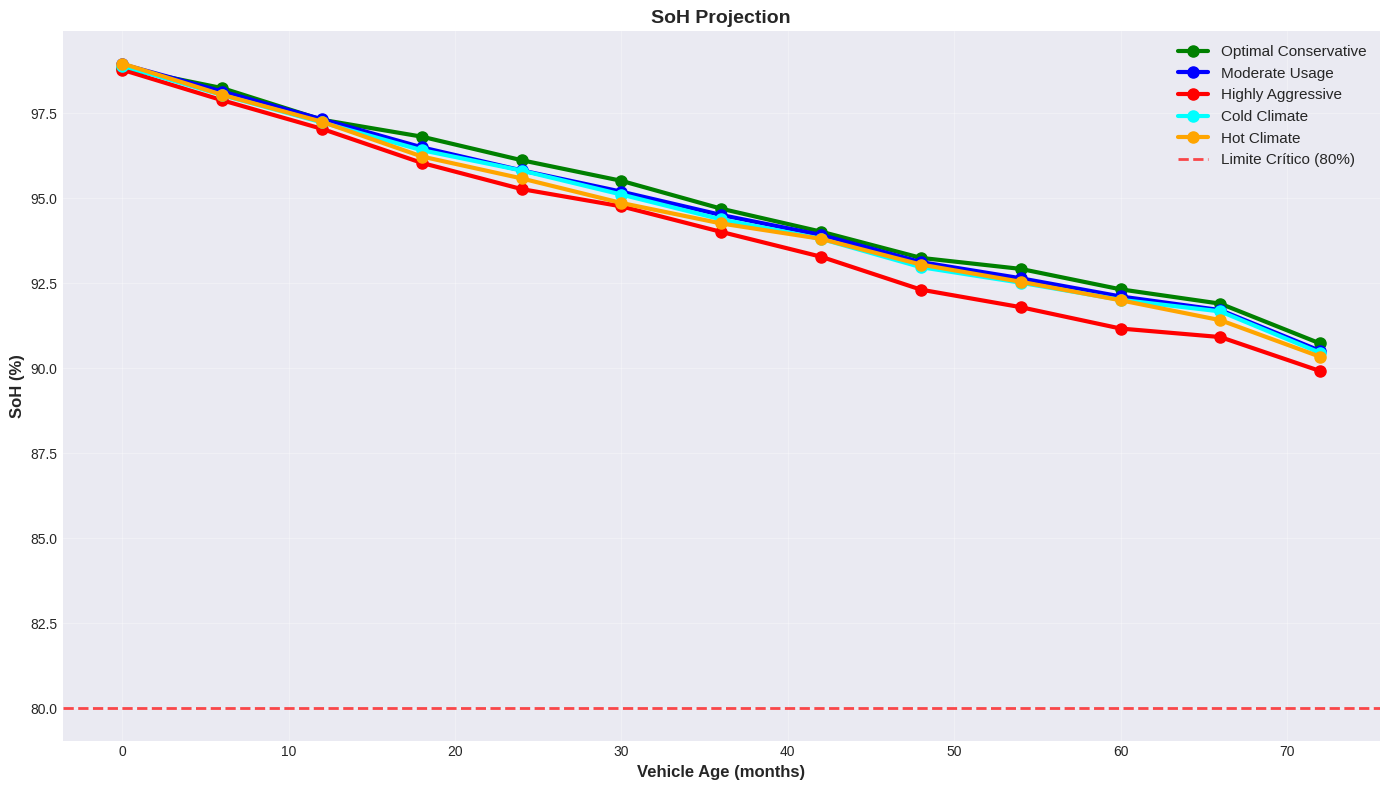

In [ ]:
scenarios = {
    'Optimal Conservative': {
        'Fast_Charge_Ratio': 0.2,
        'Avg_Temperature_C': 20,
        'Driving_Style_Encoded': le_driving.transform(['Conservative'])[0],
        'Avg_Discharge_Rate_C': 0.5
    },
    'Moderate Usage': {
        'Fast_Charge_Ratio': 0.5,
        'Avg_Temperature_C': 20,
        'Driving_Style_Encoded': le_driving.transform(['Moderate'])[0],
        'Avg_Discharge_Rate_C': 1.0
    },
    'Highly Aggressive': {
        'Fast_Charge_Ratio': 0.9,
        'Avg_Temperature_C': 30,
        'Driving_Style_Encoded': le_driving.transform(['Aggressive'])[0],
        'Avg_Discharge_Rate_C': 2.0
    },
    'Cold Climate': {
        'Fast_Charge_Ratio': 0.5,
        'Avg_Temperature_C': 5,
        'Driving_Style_Encoded': le_driving.transform(['Moderate'])[0],
        'Avg_Discharge_Rate_C': 1.0
    },
    'Hot Climate': {
        'Fast_Charge_Ratio': 0.5,
        'Avg_Temperature_C': 35,
        'Driving_Style_Encoded': le_driving.transform(['Moderate'])[0],
        'Avg_Discharge_Rate_C': 1.0
    }
}

months = np.arange(0, 73, 6)
cycles_per_month = 20
scenario_results = {}

for scenario_name, scenario_params in scenarios.items():
    soh_over_time = []
    for month in months:
        scenario_data = median_values.copy()
        scenario_data['Vehicle_Age_Months'] = month
        scenario_data['Total_Charging_Cycles'] = month * cycles_per_month
        for key, value in scenario_params.items():
            scenario_data[key] = value
        scenario_data['Internal_Resistance_Ohm'] = 0.025 + (month * 0.0003)
        pred_soh = best_model.predict(scenario_data.values.reshape(1, -1))[0]
        soh_over_time.append(pred_soh)
    scenario_results[scenario_name] = soh_over_time

fig, ax = plt.subplots(figsize=(14, 8))
scenario_colors = ['green', 'blue', 'red', 'cyan', 'orange']
for (scenario_name, soh_values), color in zip(scenario_results.items(), scenario_colors):
    ax.plot(months, soh_values, marker='o', linewidth=3, markersize=8, label=scenario_name, color=color)

ax.axhline(y=80, color='red', linestyle='--', linewidth=2, label='Limite Crítico (80%)', alpha=0.7)
ax.set_xlabel('Vehicle Age (months)', fontsize=12, fontweight='bold')
ax.set_ylabel('SoH (%)', fontsize=12, fontweight='bold')
ax.set_title('SoH Projection', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
for scenario_name, soh_values in scenario_results.items():
    final_soh = soh_values[-1]
    delta = final_soh - soh_values[0]
    print(f"   {scenario_name:20s}: {final_soh:5.2f}% (Δ: {delta:+.2f}%)")

   Optimal Conservative: 90.73% (Δ: -8.10%)
   Moderate Usage      : 90.51% (Δ: -8.42%)
   Highly Aggressive   : 89.92% (Δ: -8.86%)
   Cold Climate        : 90.45% (Δ: -8.44%)
   Hot Climate         : 90.34% (Δ: -8.62%)


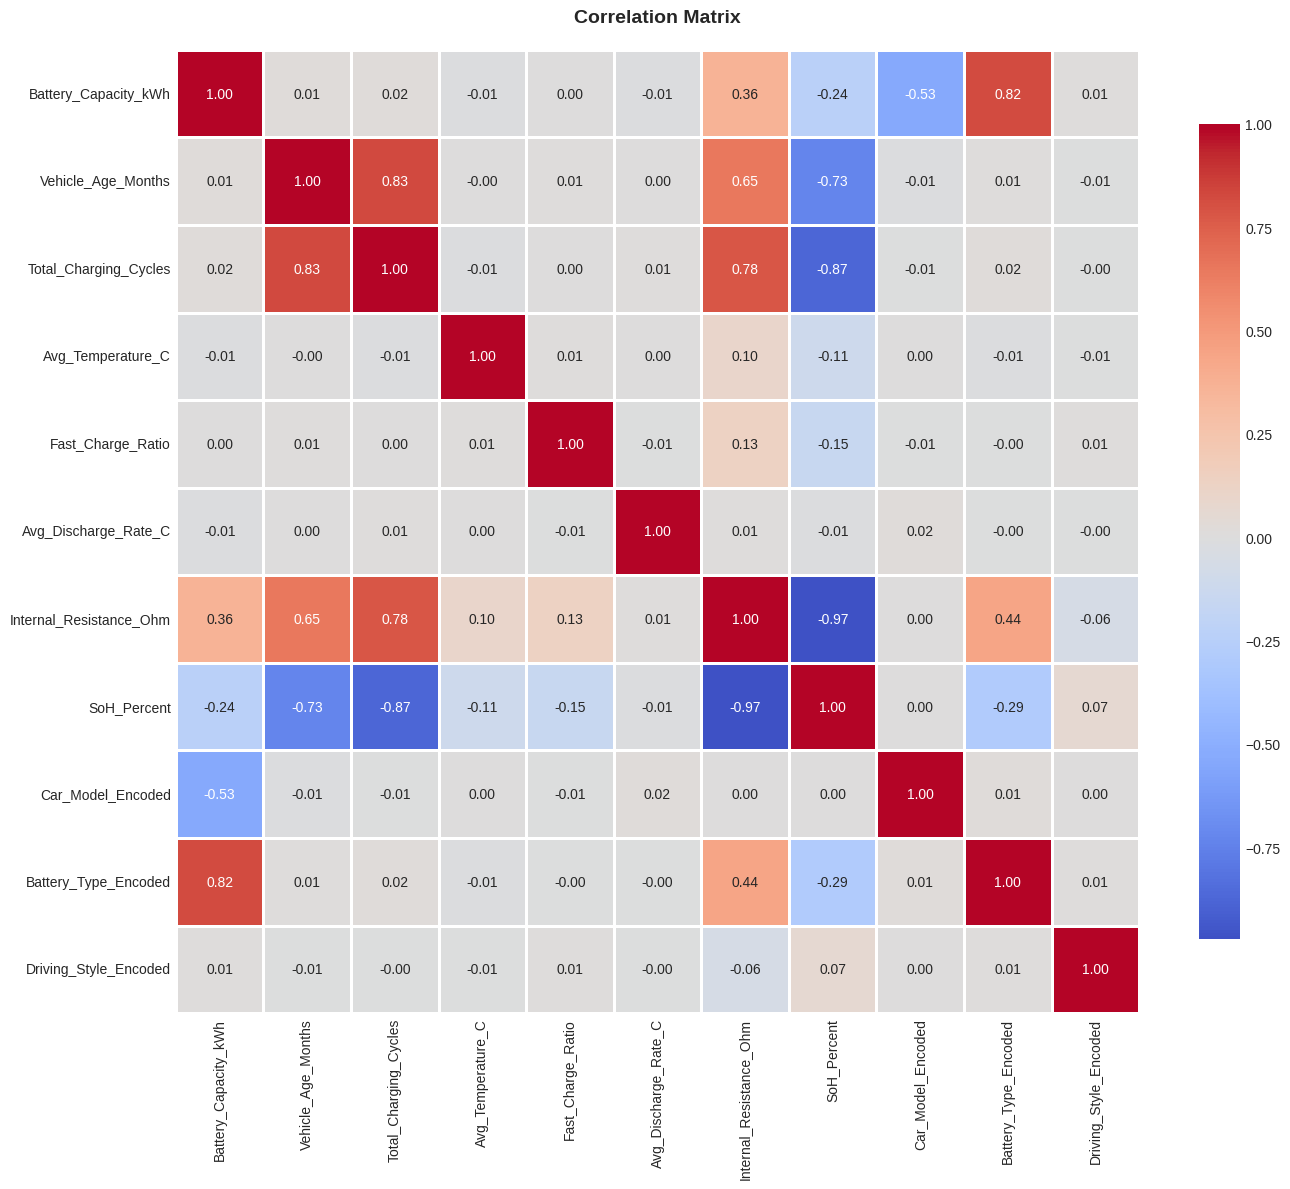

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
soh_correlations = correlation_matrix['SoH_Percent'].sort_values(ascending=False)
print("SoH_Percent:")
for feature, corr in soh_correlations.items():
    if feature != 'SoH_Percent':
        direction = '↑' if corr > 0 else '↓'
        bar = '█' * int(abs(corr) * 30)
        print(f"   {direction} {feature:30s} {bar} {corr:+.3f}")

SoH_Percent:
   ↑ Driving_Style_Encoded          █ +0.065
   ↑ Car_Model_Encoded               +0.000
   ↓ Avg_Discharge_Rate_C            -0.015
   ↓ Avg_Temperature_C              ███ -0.112
   ↓ Fast_Charge_Ratio              ████ -0.150
   ↓ Battery_Capacity_kWh           ███████ -0.238
   ↓ Battery_Type_Encoded           ████████ -0.287
   ↓ Vehicle_Age_Months             █████████████████████ -0.726
   ↓ Total_Charging_Cycles          ██████████████████████████ -0.873
   ↓ Internal_Resistance_Ohm        █████████████████████████████ -0.972


In [ ]:
print(f"   Selected Algorithm: {best_model_name}")
print(f"   R² Score: {best_r2:.4f} ({best_r2*100:.2f}% of explained variance)")
print(f"   MAE: {best_mae:.4f}% (mean absolute error)")
print(f"   RMSE: {best_rmse:.4f}% (root mean squared error)")

print(f"\nKEY FEATURES:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"   {idx+1}. {row['Feature']} ({row['Importance']*100:.1f}% of importance)")

print(f"\nDATASET STATISTICS:")
print(f"   Total Vehicles: {len(df['Vehicle_ID'].unique())}")
print(f"   Average SoH: {df['SoH_Percent'].mean():.2f}%")
print(f"   Minimum SoH: {df['SoH_Percent'].min():.2f}%")
print(f"   Maximum SoH: {df['SoH_Percent'].max():.2f}%")
print(f"   Standard Deviation: {df['SoH_Percent'].std():.2f}%")

print(f"\nDISTRIBUTION BY MODEL:")
for model, count in df['Car_Model'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"   {model}: {count} ({percentage:.1f}%)")

print(f"\nDISTRIBUTION BY DRIVING STYLE:")
for style, count in df['Driving_Style'].value_counts().items():
    percentage = (count / len(df)) * 100
    avg_soh = df[df['Driving_Style'] == style]['SoH_Percent'].mean()
    print(f"   {style:12s}: {count:4d} ({percentage:4.1f}%) - Average SoH: {avg_soh:.2f}%")

print(f"\nKEY INSIGHTS:")
top_feature = feature_importance.iloc[0]
print(f"   • {top_feature['Feature']} is the strongest predictor of degradation ({top_feature['Importance']*100:.1f}%)")

if 'Driving_Style' in df.columns:
    conservative_soh = df[df['Driving_Style']=='Conservative']['SoH_Percent'].mean()
    aggressive_soh = df[df['Driving_Style']=='Aggressive']['SoH_Percent'].mean()
    diff = conservative_soh - aggressive_soh
    print(f"   • Conservative driving maintains SoH {diff:.2f}% higher compared to aggressive driving")

print(f"   • High fast-charging proportion correlates with higher degradation")
print(f"   • Extreme temperatures (very hot or very cold) accelerate degradation")

   Selected Algorithm: Gradient Boosting
   R² Score: 0.9879 (98.79% of explained variance)
   MAE: 0.2763% (mean absolute error)
   RMSE: 0.3583% (root mean squared error)

KEY FEATURES:
   8. Internal_Resistance_Ohm (95.0% of importance)
   3. Total_Charging_Cycles (3.1% of importance)
   1. Battery_Capacity_kWh (1.3% of importance)

DATASET STATISTICS:
   Total Vehicles: 10000
   Average SoH: 95.81%
   Minimum SoH: 73.74%
   Maximum SoH: 100.00%
   Standard Deviation: 3.25%

DISTRIBUTION BY MODEL:
   BYD Atto 3: 2032 (20.3%)
   Ford Mustang Mach-E: 2009 (20.1%)
   Tesla Model 3: 2008 (20.1%)
   Hyundai Ioniq 5: 2003 (20.0%)
   Wuling Air EV: 1948 (19.5%)

DISTRIBUTION BY DRIVING STYLE:
   Moderate    : 5109 (51.1%) - Average SoH: 95.84%
   Conservative: 2952 (29.5%) - Average SoH: 96.26%
   Aggressive  : 1939 (19.4%) - Average SoH: 95.04%

KEY INSIGHTS:
   • Internal_Resistance_Ohm is the strongest predictor of degradation (95.0%)
   • Conservative driving maintains SoH 1.22% higher